In [1]:
# import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Data

In [2]:
# Read the data

data = pd.read_csv('day.csv')

In [3]:
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Clean Data

In [4]:
# Dropping 'instant', since it's just an indexing variable

data.drop(columns=['instant'], inplace=True)

In [5]:
# Dropping 'dteday', since all of the useful information from this variable is 
# available in other variables like yr, weekday, holiday, etc.

data.drop(columns=['dteday'], inplace=True)

In [6]:
# Dropping 'casual' and 'registered', since they combine to make our target 
# variable 'cnt' and have no utility otherwise

data.drop(columns=['casual', 'registered'], inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


Data appears to be clean, no imputations needed

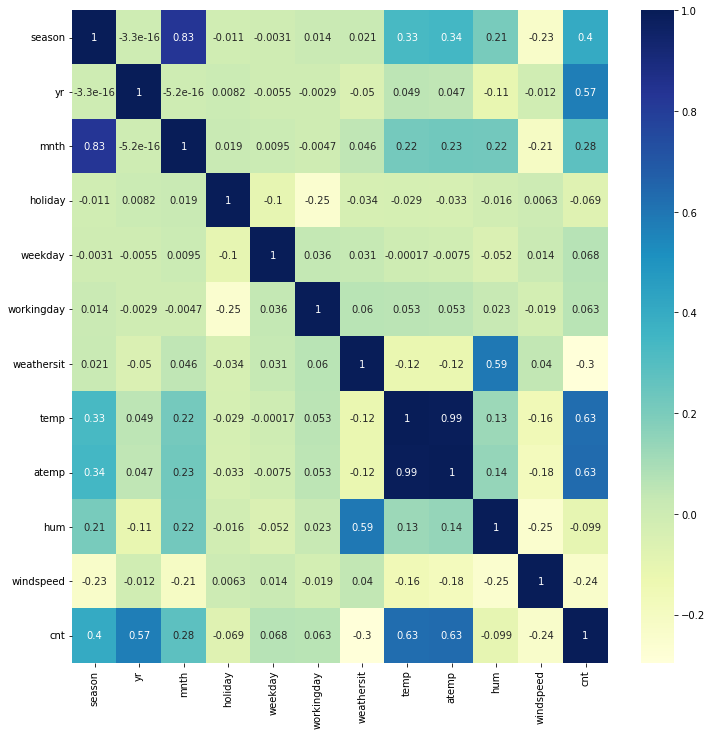

In [8]:
plt.figure(figsize=(12, 12))
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
plt.show()

### Observations

1. atemp and temp are extremely corelated
2. weathersit and hum are highly correlated
3. season is highly correlated with mnth

We're keeping temp and weathersit. Since, these parameters are more readily available to and understood by the business owners

In [9]:
# 'atemp' and 'temp' are highly correlated
# dropping 'atemp', since it's merely a combination of 'temp', 'hum' and 'windspeed'
# also dropping 'mnth', since it's highly correlated with season

data.drop(columns=['atemp', 'mnth'], inplace=True)

## Analysis

In [10]:
data.head()

,season,yr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,0,6,0,2,14.110847,80.5833,10.749882,985
1,1,0,0,0,0,2,14.902598,69.6087,16.652113,801
2,1,0,0,1,1,1,8.050924,43.7273,16.636703,1349
3,1,0,0,2,1,1,8.200000,59.0435,10.739832,1562
4,1,0,0,3,1,1,9.305237,43.6957,12.522300,1600


In [11]:
# Convert 

data['season'] = data['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
data['yr'] = data['yr'].map({0: '2018', 1: '2019'})
# data['mnth'] = data['mnth'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})

# Since, 6 and 0 both weekdays are not working days, we can assume they represent Sat and Sun respectively
data['weekday'] = data['weekday'].map({0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'})
data['weathersit'] = data['weathersit'].map({1: 'Clear', 2: 'Cloudy', 3: 'Light_Rain', 4: 'Heavy_Rain'})

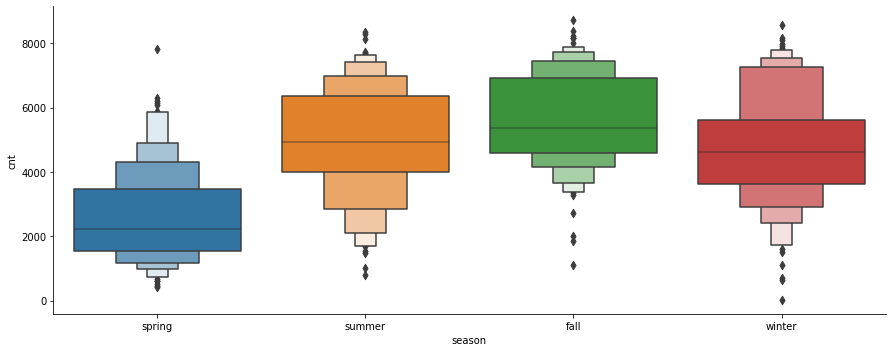

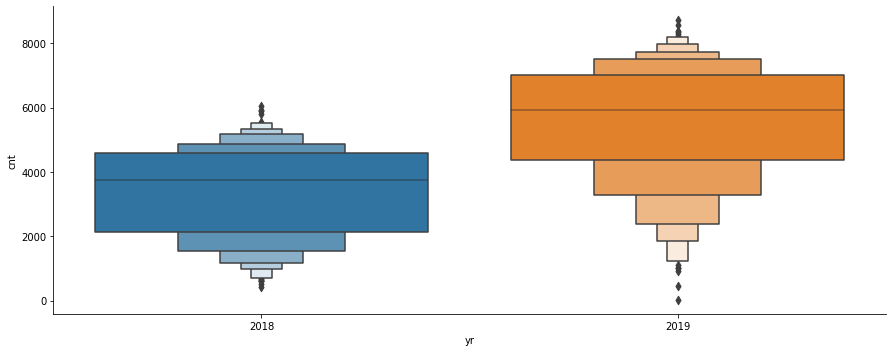

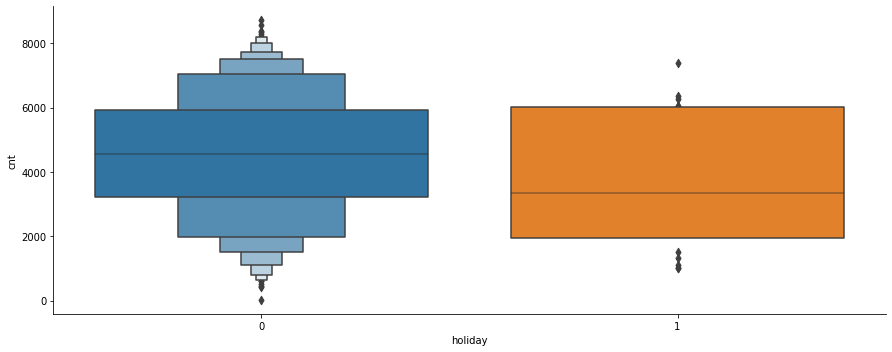

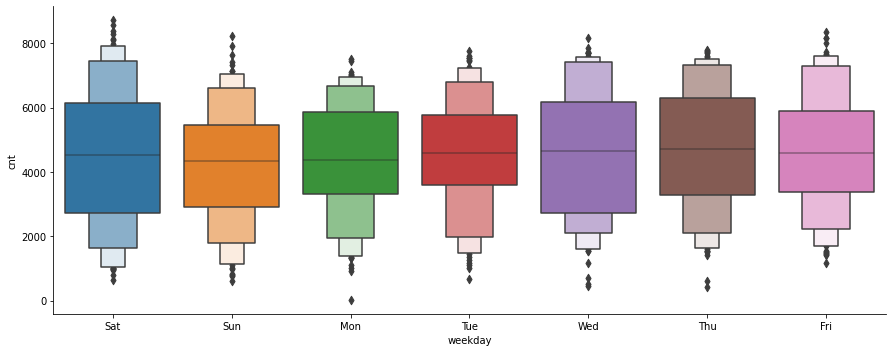

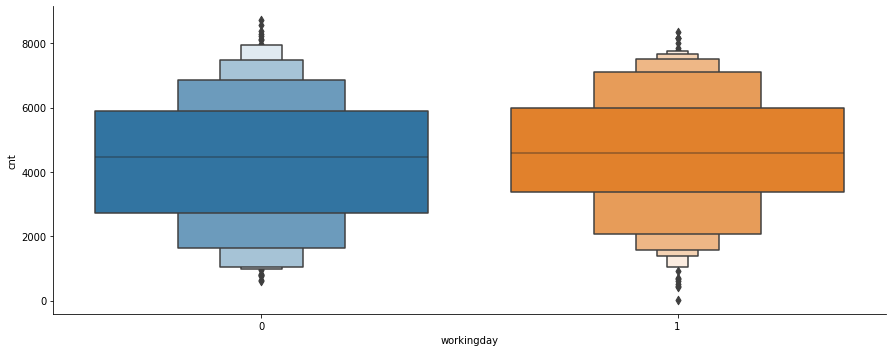

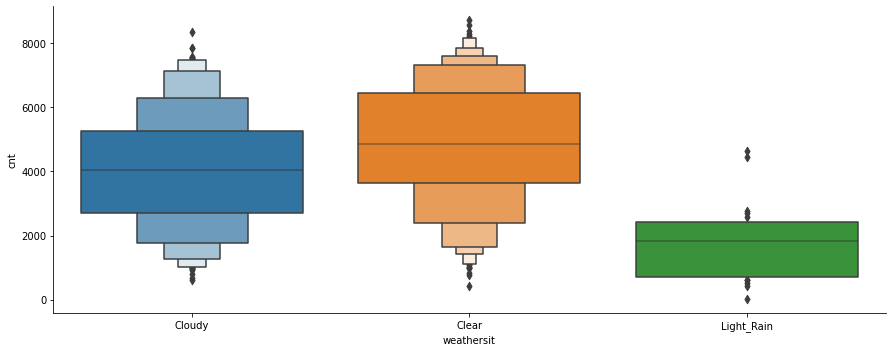

In [12]:
for column in ['season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit']:
  sns.catplot(data=data, x=column, y='cnt', kind='boxen', height=5, aspect=2.5)
  plt.show()

In [13]:
data.describe()

,holiday,workingday,temp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.028767,0.683562,20.319259,62.765175,12.763620,4508.006849
std,0.167266,0.465405,7.506729,14.237589,5.195841,1936.011647
min,0.000000,0.000000,2.424346,0.000000,1.500244,22.000000
25%,0.000000,0.000000,13.811885,52.000000,9.041650,3169.750000
50%,0.000000,1.000000,20.465826,62.625000,12.125325,4548.500000
75%,0.000000,1.000000,26.880615,72.989575,15.625589,5966.000000
max,1.000000,1.000000,35.328347,97.250000,34.000021,8714.000000


In [14]:
data.corr().cnt.sort_values(ascending=False)

cnt           1.000000
temp          0.627044
workingday    0.062542
holiday      -0.068764
hum          -0.098543
windspeed    -0.235132
Name: cnt, dtype: float64

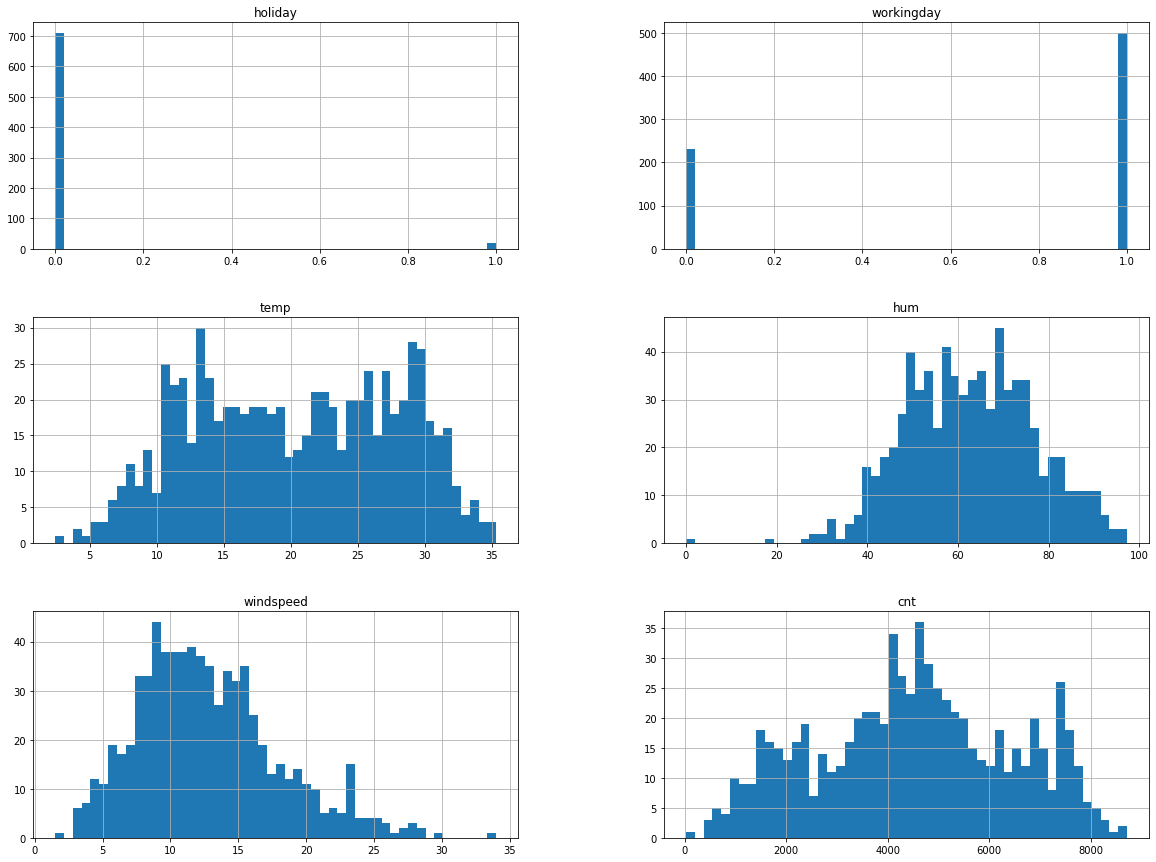

In [15]:
data.hist(bins=50,figsize=(20,15))
plt.show()

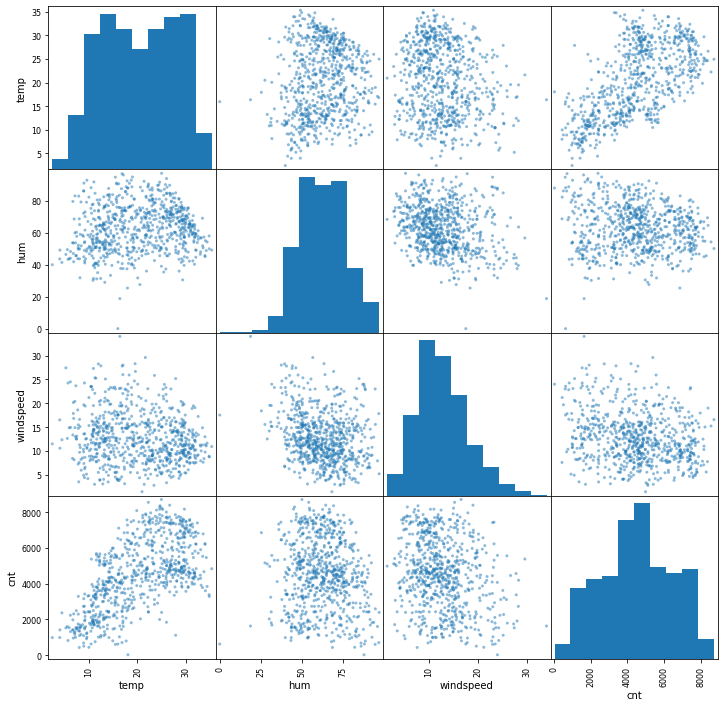

In [16]:
# Draw scatter plots for numerical data
scatter_matrix(data[["temp", "hum", "windspeed",
              "cnt"]], figsize=(12, 12))
plt.show()

In [17]:
data.corr().cnt.sort_values(ascending=False)

cnt           1.000000
temp          0.627044
workingday    0.062542
holiday      -0.068764
hum          -0.098543
windspeed    -0.235132
Name: cnt, dtype: float64

## Create dummy variables for categorical data

In [18]:
# Create dummy variables to replace categorical values
data = pd.get_dummies(data, drop_first=True)
data.head().T

,0,1,2,3,4
holiday,0.000000,0.000000,0.000000,0.000000,0.000000
workingday,0.000000,0.000000,1.000000,1.000000,1.000000
temp,14.110847,14.902598,8.050924,8.200000,9.305237
hum,80.583300,69.608700,43.727300,59.043500,43.695700
windspeed,10.749882,16.652113,16.636703,10.739832,12.522300
cnt,985.000000,801.000000,1349.000000,1562.000000,1600.000000
season_spring,1.000000,1.000000,1.000000,1.000000,1.000000
season_summer,0.000000,0.000000,0.000000,0.000000,0.000000
season_winter,0.000000,0.000000,0.000000,0.000000,0.000000
yr_2019,0.000000,0.000000,0.000000,0.000000,0.000000


## Splitting the Data into Training and Testing Sets

In [19]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=100)

In [20]:
train_set.shape

(584, 18)

In [21]:
test_set.shape

(146, 18)

## Rescaling the Features
We will use MinMax scaling.

In [22]:
num_variables = ['temp', 'hum', 'windspeed']

In [23]:
scaler = MinMaxScaler()
train_set[num_variables] = scaler.fit_transform(train_set[num_variables])
train_set.describe()

,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,yr_2019,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Cloudy,weathersit_Light_Rain
count,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000
mean,0.027397,0.667808,0.537414,0.649499,0.319463,4505.267123,0.251712,0.246575,0.250000,0.513699,0.148973,0.150685,0.154110,0.135274,0.133562,0.154110,0.342466,0.027397
std,0.163378,0.471403,0.225336,0.144219,0.168114,1958.617712,0.434369,0.431387,0.433384,0.500241,0.356367,0.358048,0.361363,0.342309,0.340472,0.361363,0.474941,0.163378
min,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.340113,0.535852,0.199177,3070.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.545191,0.653714,0.294764,4566.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.736512,0.752361,0.410413,6035.750000,1.000000,0.000000,0.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,8714.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Dividing into X and Y sets for the model building

In [24]:
x_train = train_set.drop("cnt", axis = 1)
y_train = train_set["cnt"].copy()

## Model Building

In [25]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(x_train, y_train)

rfe = RFE(lm, n_features_to_select=10, step=1)
rfe = rfe.fit(x_train, y_train)

In [26]:
# selected columns
col = x_train.columns[rfe.support_]
col

Index(['holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_spring',
       'yr_2019', 'weekday_Sat', 'weekday_Sun', 'weathersit_Light_Rain'],
      dtype='object')

In [27]:
# dropped columns
x_train.columns[~rfe.support_]

Index(['season_summer', 'season_winter', 'weekday_Mon', 'weekday_Thu',
       'weekday_Tue', 'weekday_Wed', 'weathersit_Cloudy'],
      dtype='object')

In [28]:
x_train_rfe = x_train[col]

In [29]:
def analyse_variables(x_train, y_train):
  x_train_sm = sm.add_constant(x_train)
  lr = sm.OLS(y_train, x_train_sm)
  lr_model = lr.fit()
  print(lr_model.summary())

  # VIF
  vif = pd.DataFrame()
  vif['Features'] = x_train.columns
  vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = 'VIF', ascending=False)
  print(vif)

In [30]:
# initial analysis
x_train_new = x_train_rfe
analyse_variables(x_train_new, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     283.9
Date:                Mon, 20 Jun 2022   Prob (F-statistic):          7.57e-205
Time:                        08:50:12   Log-Likelihood:                -4759.7
No. Observations:                 584   AIC:                             9539.
Df Residuals:                     574   BIC:                             9583.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2889.06

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [31]:
# dropping holiday since it has a very high p value
x_train_new = x_train_new.drop('holiday', axis=1)
analyse_variables(x_train_new, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     283.9
Date:                Mon, 20 Jun 2022   Prob (F-statistic):          7.57e-205
Time:                        08:50:13   Log-Likelihood:                -4759.7
No. Observations:                 584   AIC:                             9539.
Df Residuals:                     574   BIC:                             9583.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3061.12

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


We observe no drop in Adj. R-squared

In [32]:
# dropping weekday_Sun since it has a high p value
x_train_new = x_train_new.drop('weekday_Sun', axis=1)
analyse_variables(x_train_new, y_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     317.5
Date:                Mon, 20 Jun 2022   Prob (F-statistic):          2.40e-205
Time:                        08:50:13   Log-Likelihood:                -4761.5
No. Observations:                 584   AIC:                             9541.
Df Residuals:                     575   BIC:                             9580.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3425.70

### Observation

We observe a slight drop in Adj. R-squared

In [33]:
# Dropping hum due to high VIF

x_train_new = x_train_new.drop('hum', axis=1)
analyse_variables(x_train_new, y_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     328.2
Date:                Mon, 20 Jun 2022   Prob (F-statistic):          2.43e-196
Time:                        08:50:13   Log-Likelihood:                -4785.6
No. Observations:                 584   AIC:                             9587.
Df Residuals:                     576   BIC:                             9622.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2073.88

### Observation

We observe a slight drop in Adj. R-squared

## Training

In [34]:
# Train linear regression model
lin_reg = LinearRegression()
lin_reg.fit(x_train_new, y_train)

LinearRegression()

In [35]:
lin_reg.intercept_

2073.887098387548

In [36]:
pd.DataFrame(lin_reg.coef_, 
             x_train_new.columns, 
             columns=['coef'])

,coef
workingday,469.434119
temp,3375.337455
windspeed,-1310.793748
season_spring,-1358.301968
yr_2019,2024.568787
weekday_Sat,569.888173
weathersit_Light_Rain,-2237.736970


### Final equation

cnt = 2074 + 469 * workingday + 3375 * temp - 1311 * windspeed - 1358 * season_spring + 2025 * yr_2019 + 570 * weekday_sat - 2238 * weathersit_Light_Rain

In [36]:
# RMSE for the model
predictions = lin_reg.predict(x_train_new)

lin_mse = mean_squared_error(y_train, predictions)

lin_rmse = np.sqrt(lin_mse)
lin_rmse

876.2096332662724

In [37]:
# R2 for the model
r2_score(y_train, predictions)

0.7995246481205452

Model has 80% accuracy on training data

<function matplotlib.pyplot.show>

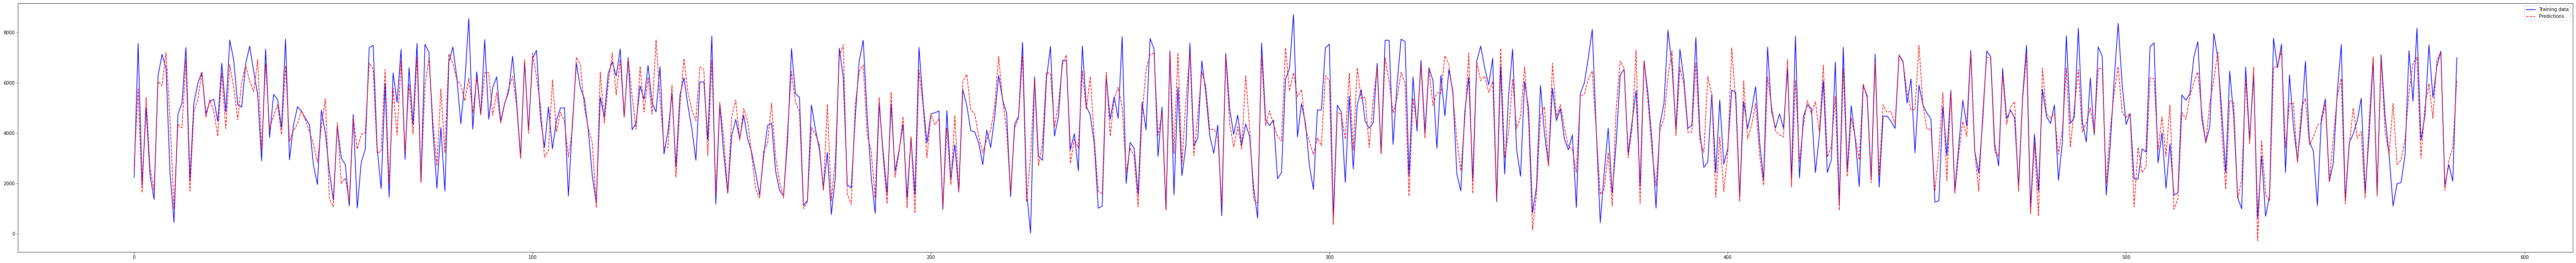

In [39]:
# check prediction fit

plt.figure(figsize=(100, 10))
line1, line2 = plt.plot(y_train.values, 'b-', predictions, 'r--')
line1.set_label('Training data')
line2.set_label('Predictions')
plt.legend()
plt.show

Text(0, 0.5, 'y_pred')

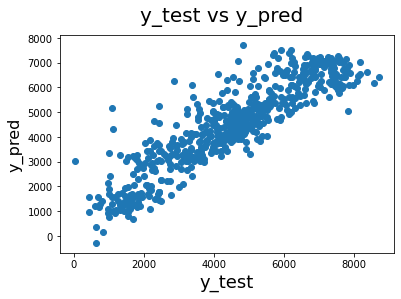

In [40]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_train, predictions)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

## Residual Analysis

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


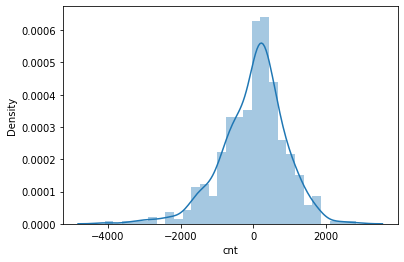

In [38]:
res = y_train - predictions
sns.distplot(res)
plt.show()

Error are normally distributed around mean 0

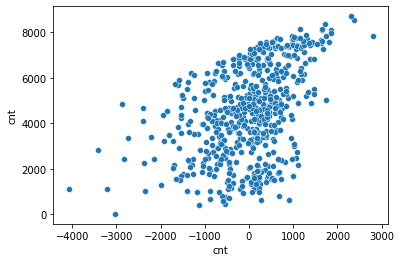

In [39]:
sns.scatterplot(x=res, y=y_train)
plt.show()

Errors are independent and have a constant variance

# Check accuracy of model

## Applying the scaling on the test sets

In [40]:
test_set[num_variables] = scaler.transform(test_set[num_variables])

## Dividing into x_test and y_test

In [41]:
x_test = test_set.drop("cnt", axis = 1)
y_test = test_set["cnt"].copy()

In [42]:
# Now let's use our model to make predictions.

# Creating x_test_new dataframe by dropping variables from X_test
x_test_new = x_test[x_train_new.columns]

In [43]:
# Making predictions
y_test_pred = lin_reg.predict(x_test_new)

In [44]:
r2_score(y_test, y_test_pred)

0.747384454115447

The model has about 75% accuracy on test dataset. It generalises fairly well on unknown data.

Text(0, 0.5, 'y_pred')

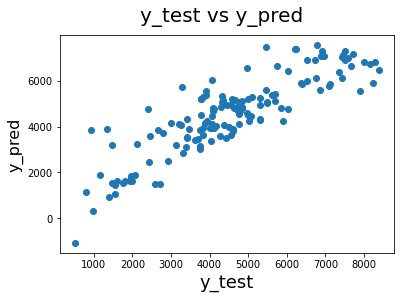

In [45]:
# Plotting y_test and y_test_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

# Conclusions

### Final equation

cnt = 2074 + 469 * workingday + 3375 * temp - 1311 * windspeed - 1358 * season_spring + 2025 * yr_2019 + 570 * weekday_sat - 2238 * weathersit_Light_Rain

### Understanding Final equation

1. On a working day there is an excess demand of 469 bikes
2. Temperature is responsible for a variation of 3375 in demand. Higher the temp, higher the demand.
3. Windspeed is responsible for a variation of 1311 in demand. Higher the windspeed, lower the demand.
4. During spring, there is a drop in demand amounting to 1358
5. Year 2019 saw demand increase by 2025.
6. There's an excess demand of 570 on Saturday
7. Demand drops by 2238 when there is light rain